In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms.bipartite.basic import color

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
# --- Models ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier       # Need to install: pip install xgboost
from lightgbm import LGBMClassifier     # Need to install: pip install lightgbm

In [6]:
# --- Evaluation ---
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

In [7]:
# --- Configuration ---
DATASET_PATH = 'synthetic_indoor_plant_data.csv'
TEST_SET_SIZE = 0.2
RANDOM_STATE = 42 # for reproducibility

In [8]:
# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

In [9]:
# --- Load Data ---
print(f"Loading dataset from: {DATASET_PATH}")
try:
    # Try parsing dates, fallback if it fails
    try:
        df = pd.read_csv(DATASET_PATH, parse_dates=['Timestamp'])
    except Exception:
        print("Warning: Could not parse 'Timestamp' as date. Treating as object.")
        df = pd.read_csv(DATASET_PATH)

    print("Dataset loaded successfully.")
    print("Dataset shape:", df.shape)
    print("First 5 rows:\n", df.head())
    print("\nData types:\n", df.dtypes)
    print("\nMissing values:\n", df.isnull().sum())
    print("\nTarget variable distribution (Water_Needed):")
    print(df['Water_Needed'].value_counts(normalize=True))

except FileNotFoundError:
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

Loading dataset from: synthetic_indoor_plant_data.csv
Dataset loaded successfully.
Dataset shape: (2500, 8)
First 5 rows:
                    Timestamp Plant_Type Pot_Size  Soil_Moisture  Temperature  \
0 2023-01-01 00:12:43.855271   Tropical    Small          59.54        25.88   
1 2023-01-01 00:28:55.427852       Herb   Medium          46.18        16.48   
2 2023-01-01 00:46:03.637147       Herb    Small          69.03        19.19   
3 2023-01-01 00:59:33.956777  Flowering    Large          38.84        19.56   
4 2023-01-01 01:18:36.932623  Succulent   Medium          19.57        20.35   

   Humidity  Light_Level  Water_Needed  
0     65.09      6951.21             0  
1     57.87      7675.03             1  
2     57.55     12625.83             0  
3     64.61      6687.73             1  
4     48.31     14751.09             0  

Data types:
 Timestamp        datetime64[ns]
Plant_Type               object
Pot_Size                 object
Soil_Moisture           float64
Temperat

In [10]:
# --- Exploratory Data Analysis (EDA) ---
print("\n--- Starting Exploratory Data Analysis (EDA) ---")


--- Starting Exploratory Data Analysis (EDA) ---


In [11]:
# Identify numerical and categorical features (excluding target)
all_numerical_features = df.select_dtypes(include=np.number).columns.tolist()
all_categorical_features = df.select_dtypes(exclude=np.number).columns.tolist()
if 'Water_Needed' in all_numerical_features:
    all_numerical_features.remove('Water_Needed')
if 'Timestamp' in all_categorical_features:
     all_categorical_features.remove('Timestamp') # Remove Timestamp if loaded as object
elif 'Timestamp' in all_numerical_features: # If loaded as number somehow
    all_numerical_features.remove('Timestamp')

print("Numerical features for EDA:", all_numerical_features)
print("Categorical features for EDA:", all_categorical_features)

Numerical features for EDA: ['Soil_Moisture', 'Temperature', 'Humidity', 'Light_Level']
Categorical features for EDA: ['Plant_Type', 'Pot_Size']



Generating Histograms for Numerical Features...


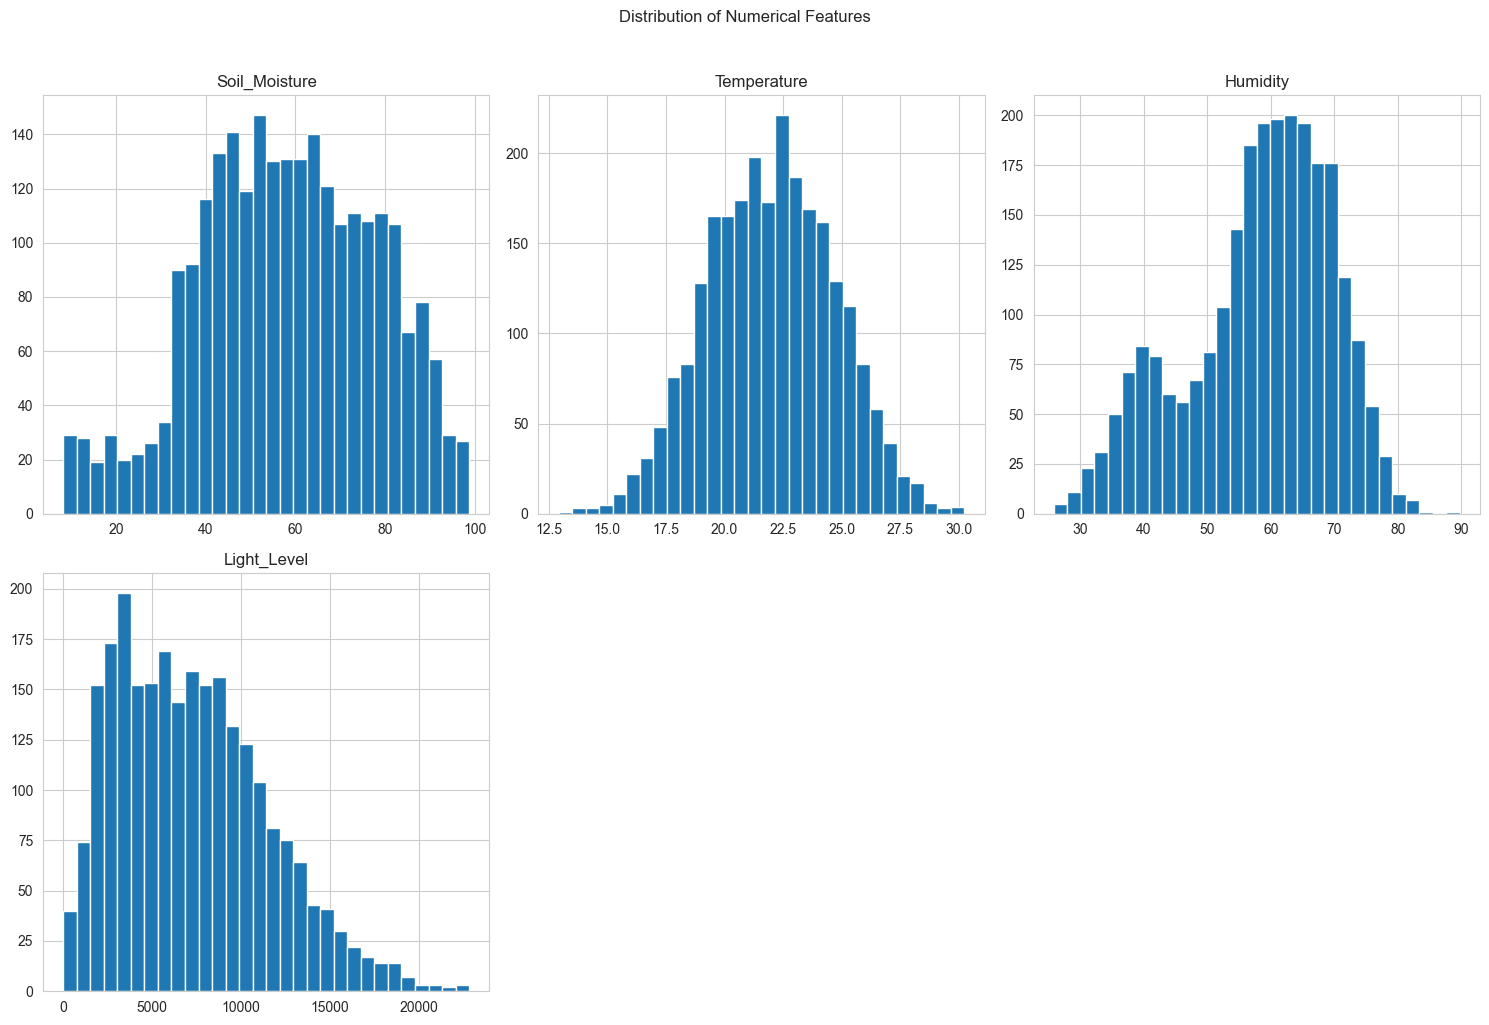

In [12]:
# 1. Histograms for Numerical Features
print("\nGenerating Histograms for Numerical Features...")
df[all_numerical_features].hist(bins=30, figsize=(15, 10), layout=(-1, 3))
plt.suptitle('Distribution of Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

Generating Count Plots for Categorical Features...


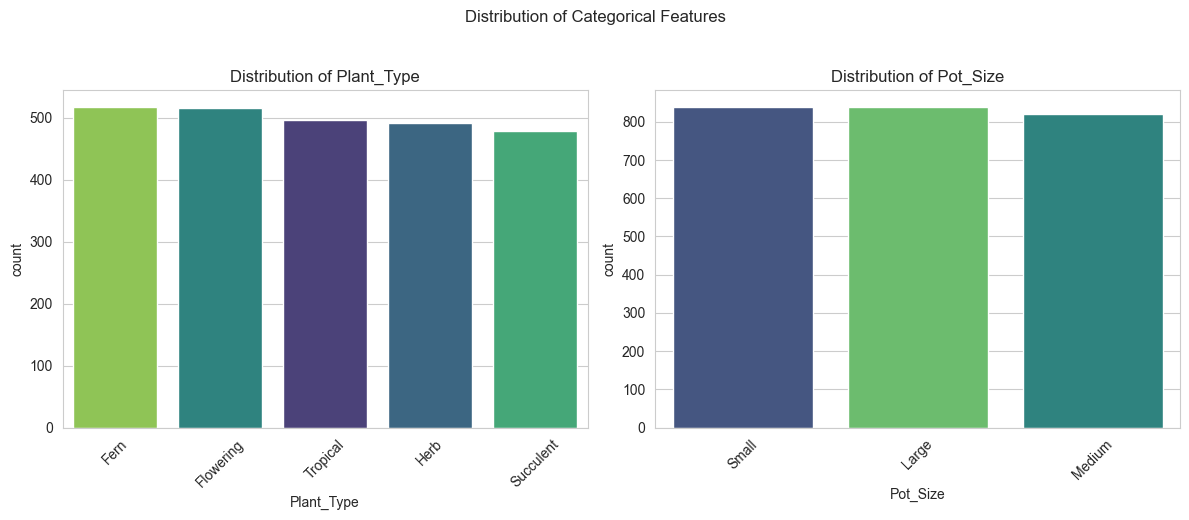

In [13]:
# 2. Count Plots for Categorical Features
print("Generating Count Plots for Categorical Features...")
num_cat_features = len(all_categorical_features)
if num_cat_features > 0:
    fig, axes = plt.subplots(nrows=(num_cat_features + 1) // 2, ncols=2, figsize=(12, 5 * ((num_cat_features + 1) // 2)))
    axes = axes.flatten() # Flatten the axes array for easy iteration
    for i, col in enumerate(all_categorical_features):
        sns.countplot(
            data=df,
            x=col,
            hue=col,
            palette='viridis',
            ax=axes[i],
            order=df[col].value_counts().index,
            legend=False
        )
        axes[i].set_title(f'Distribution of {col}')
        axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle('Distribution of Categorical Features', y=1.03)
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features found for count plots.")

Generating Box Plots (Numerical Features vs. Water_Needed)...


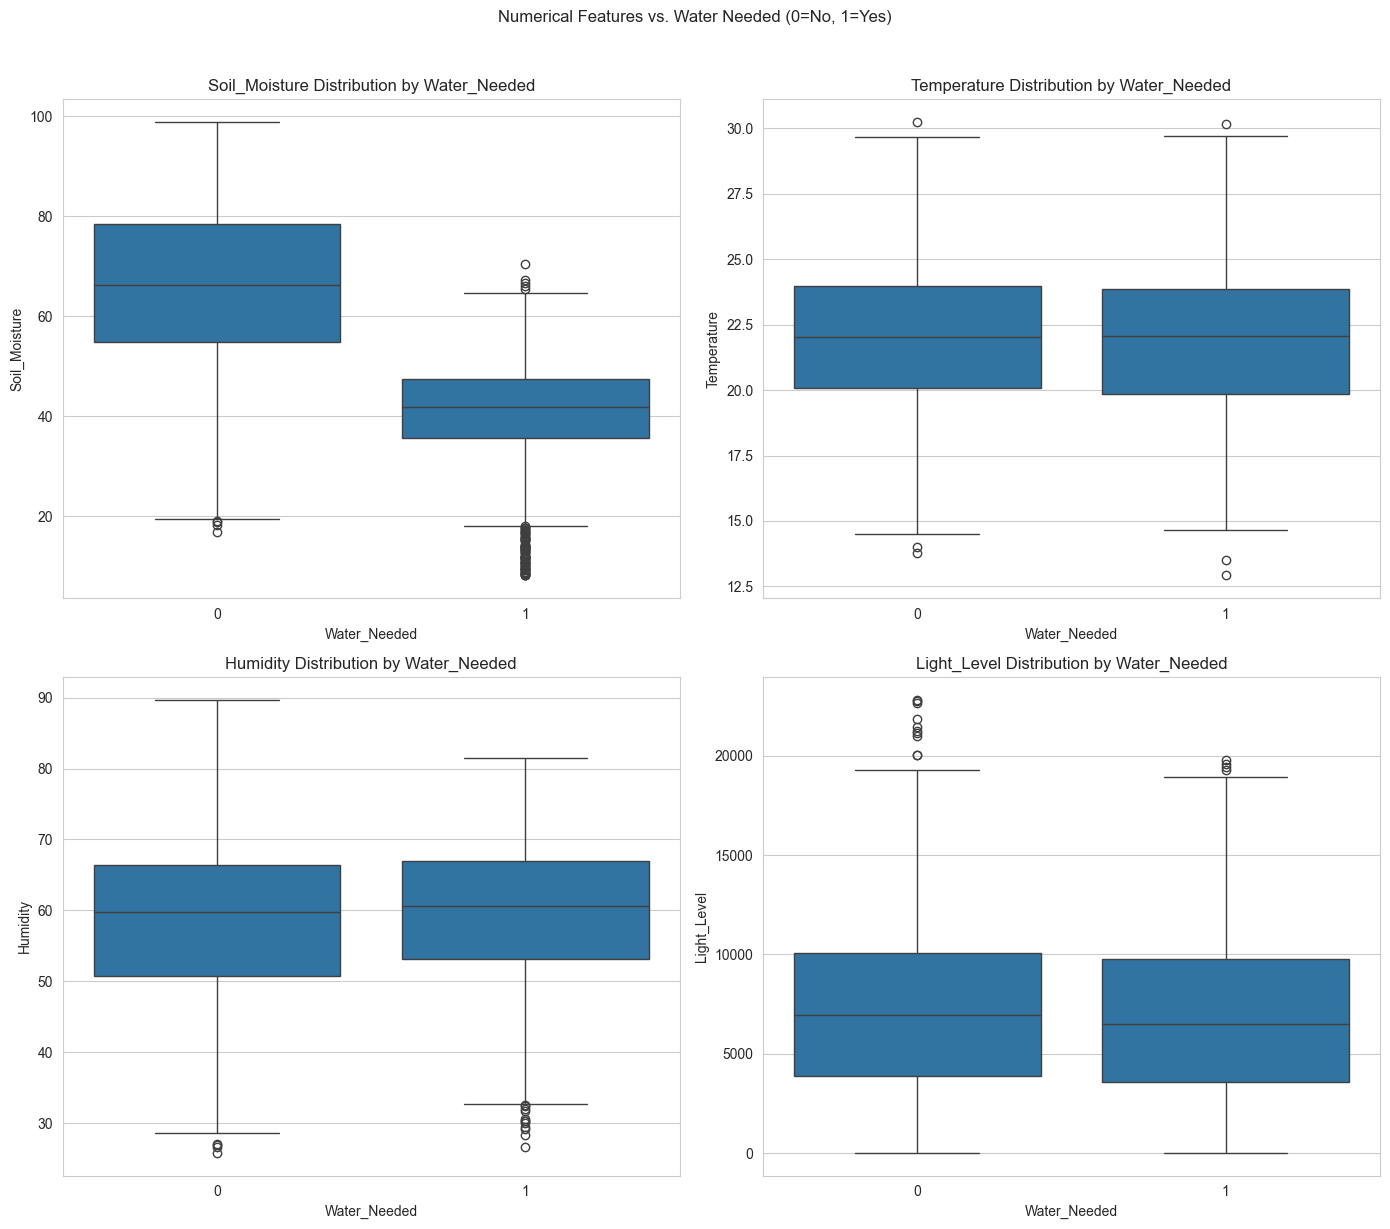

In [14]:
print("Generating Box Plots (Numerical Features vs. Water_Needed)...")
num_num_features = len(all_numerical_features)

if num_num_features > 0:
    # Determine subplot layout dynamically
    ncols = 2
    nrows = (num_num_features + 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = np.array(axes).flatten()  # Ensure axes is an array even if single row

    for idx, col in enumerate(all_numerical_features):
        sns.boxplot(
            data=df,
            x='Water_Needed',
            y=col,
            ax=axes[idx],
            legend=True,
            color="red"# Disable legend as it will be redundant

        )
        axes[idx].set_title(f"{col} Distribution by Water_Needed")

    # Hide any unused axes
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Numerical Features vs. Water Needed (0=No, 1=Yes)', y=1.02)
    plt.tight_layout()
    plt.show()

else:
    print("No numerical features found for box plots.")


Generating Correlation Heatmap for Numerical Features...


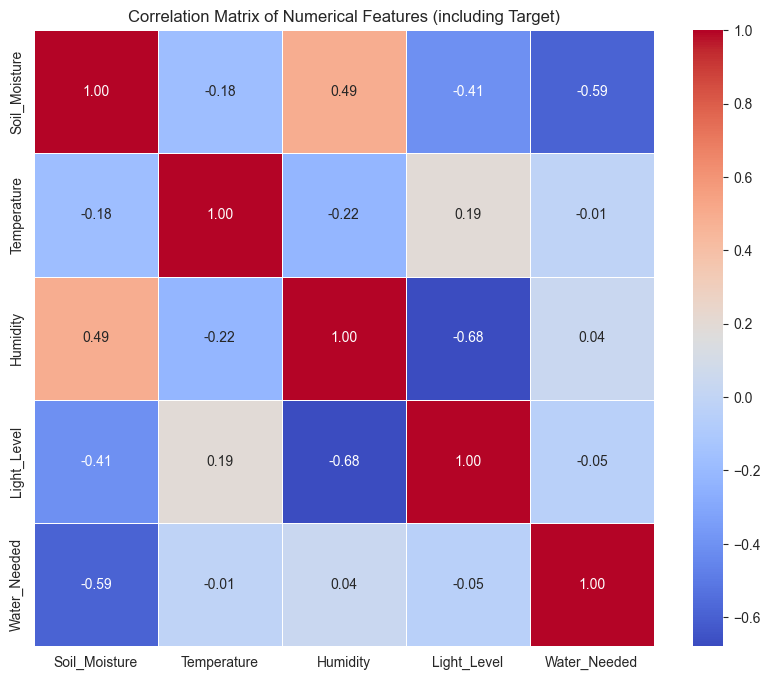

In [15]:
# 4. Correlation Heatmap
print("Generating Correlation Heatmap for Numerical Features...")
if len(all_numerical_features) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[all_numerical_features + ['Water_Needed']].corr() # Include target in corr
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features (including Target)')
    plt.show()
else:
     print("Not enough numerical features for a correlation heatmap.")

In [16]:
# --- Feature Engineering & Selection ---
# Drop Timestamp as it's not directly used for this prediction model
# Features (X) are all columns except Timestamp and the target Water_Needed
# Target (y) is the Water_Needed column
try:
    X = df.drop(['Timestamp', 'Water_Needed'], axis=1, errors='ignore') # Ignore error if Timestamp wasn't loaded
    y = df['Water_Needed']

    # Identify numerical and categorical features *for the model*
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    print("\nFeatures for Model identified:")
    print("Numerical:", numerical_features)
    print("Categorical:", categorical_features)
    print("Target:", y.name)

except KeyError as e:
    print(f"Error: Column {e} not found in the dataset. Please check column names.")
    exit()
except Exception as e:
     print(f"An error occurred during feature selection: {e}")
     exit()


Features for Model identified:
Numerical: ['Soil_Moisture', 'Temperature', 'Humidity', 'Light_Level']
Categorical: ['Plant_Type', 'Pot_Size']
Target: Water_Needed


In [17]:
# --- Data Splitting ---
print(f"\nSplitting data into training ({1-TEST_SET_SIZE:.0%}) and testing ({TEST_SET_SIZE:.0%}) sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SET_SIZE,
    random_state=RANDOM_STATE,
    stratify=y  # Important for classification to maintain class proportions
)


Splitting data into training (80%) and testing (20%) sets...


In [18]:
print("Data split complete.")
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Data split complete.
Training set shape: (2000, 6) (2000,)
Testing set shape: (500, 6) (500,)


In [19]:
# --- Preprocessing Pipeline ---
print("\nDefining preprocessing steps...")
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessor defined.")


Defining preprocessing steps...
Preprocessor defined.


In [20]:
# --- Model Definitions ---
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "SVM": SVC(random_state=RANDOM_STATE, probability=True), # Need probability=True for ROC/PR curves
    "XGBoost": XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1)
}

In [21]:
results = {}


--- Starting Model Training & Evaluation ---

===== Training KNN =====
Training completed in 0.0115 seconds.
Making predictions with KNN...
Prediction completed in 0.0333 seconds.

--- Evaluating KNN ---
Accuracy: 0.9140
Weighted F1-Score: 0.9134

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       355
           1       0.87      0.83      0.85       145

    accuracy                           0.91       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.91      0.91      0.91       500



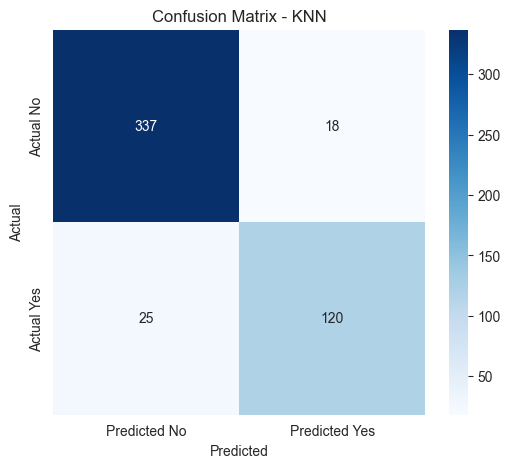

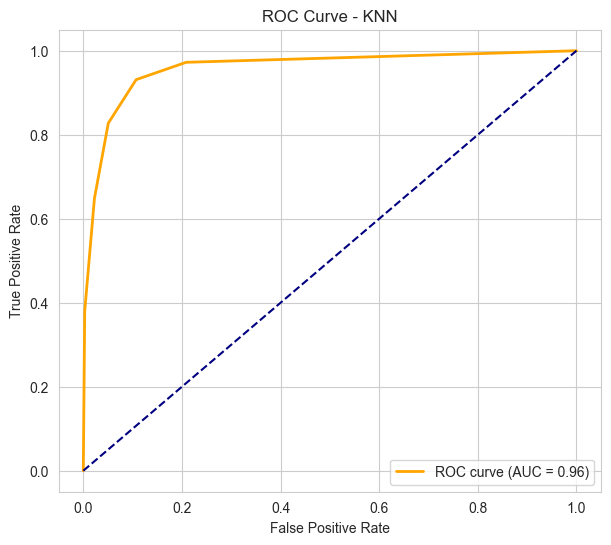

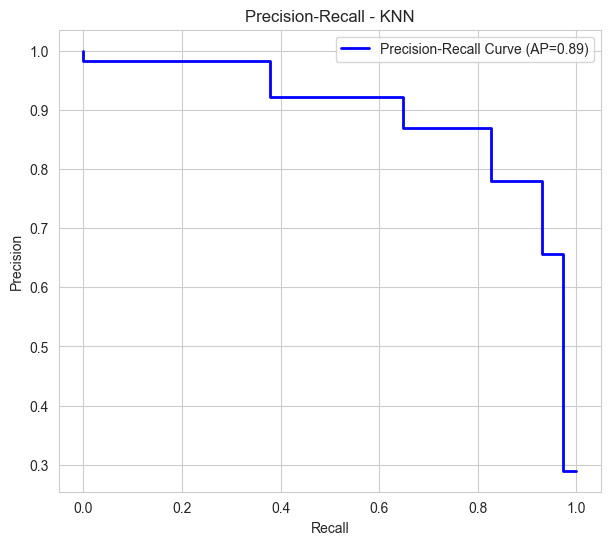


===== Training Decision Tree =====
Training completed in 0.0121 seconds.
Making predictions with Decision Tree...
Prediction completed in 0.0075 seconds.

--- Evaluating Decision Tree ---
Accuracy: 0.9060
Weighted F1-Score: 0.9057

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       355
           1       0.85      0.83      0.84       145

    accuracy                           0.91       500
   macro avg       0.89      0.88      0.89       500
weighted avg       0.91      0.91      0.91       500



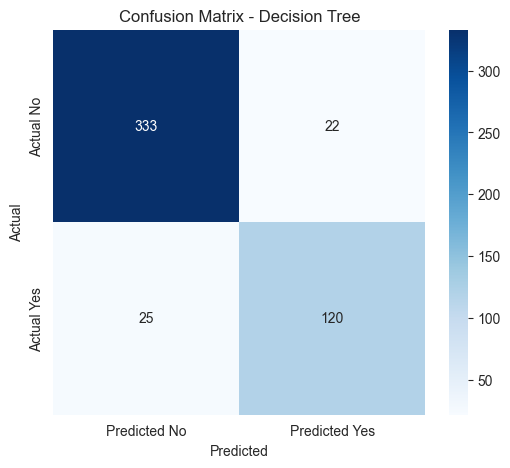

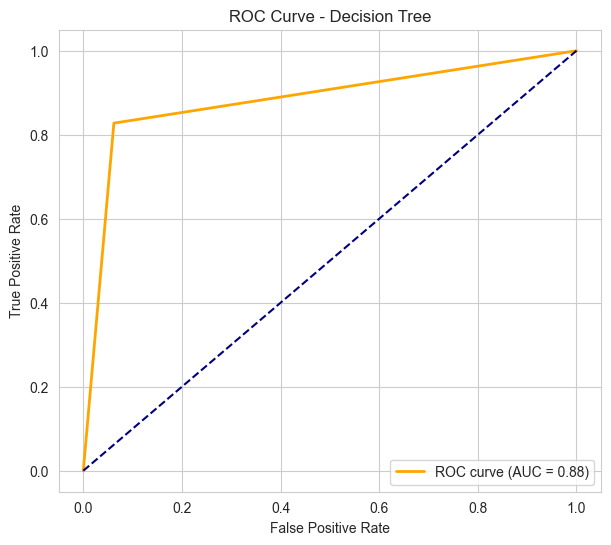

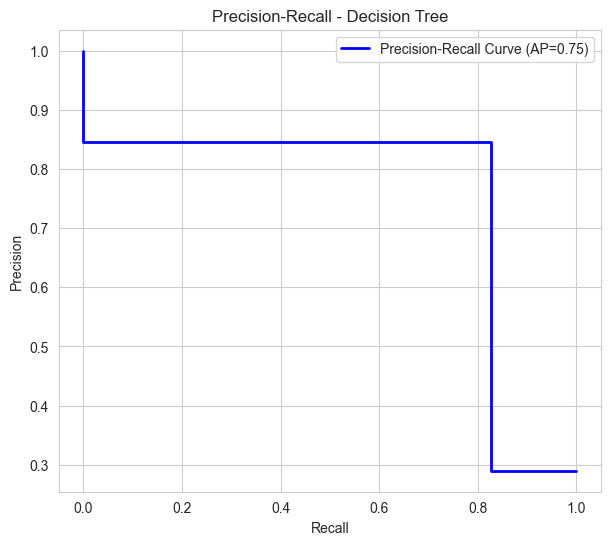


===== Training SVM =====
Training completed in 0.1665 seconds.
Making predictions with SVM...
Prediction completed in 0.0318 seconds.

--- Evaluating SVM ---
Accuracy: 0.9460
Weighted F1-Score: 0.9459

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       355
           1       0.91      0.90      0.91       145

    accuracy                           0.95       500
   macro avg       0.94      0.93      0.93       500
weighted avg       0.95      0.95      0.95       500



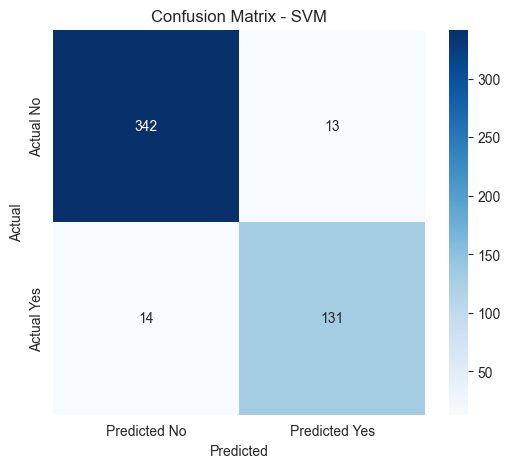

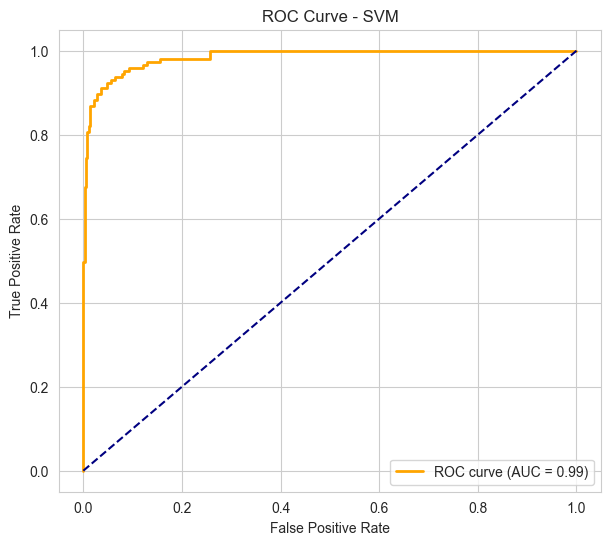

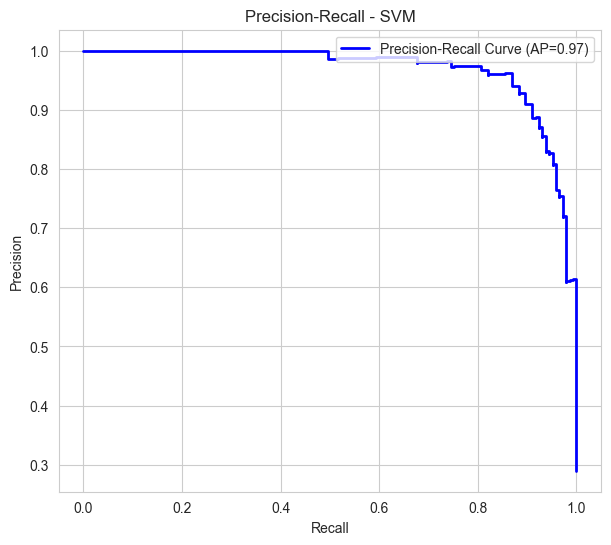


===== Training XGBoost =====
Training completed in 0.0563 seconds.
Making predictions with XGBoost...
Prediction completed in 0.0110 seconds.

--- Evaluating XGBoost ---
Accuracy: 0.9460
Weighted F1-Score: 0.9461

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       355
           1       0.90      0.91      0.91       145

    accuracy                           0.95       500
   macro avg       0.93      0.94      0.93       500
weighted avg       0.95      0.95      0.95       500



C:\Users\Satyam\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:39:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


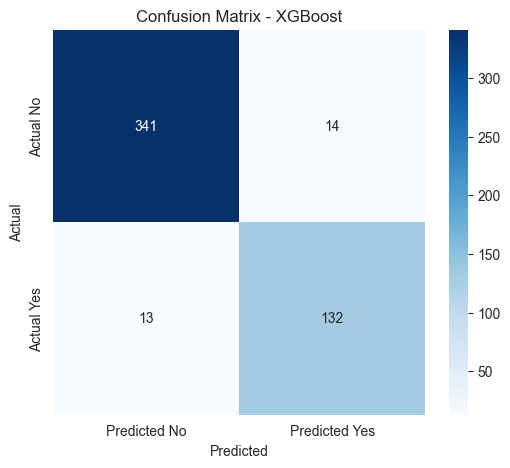

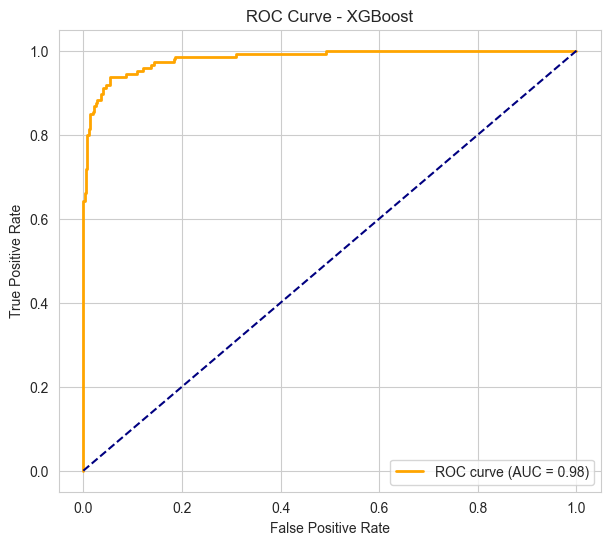

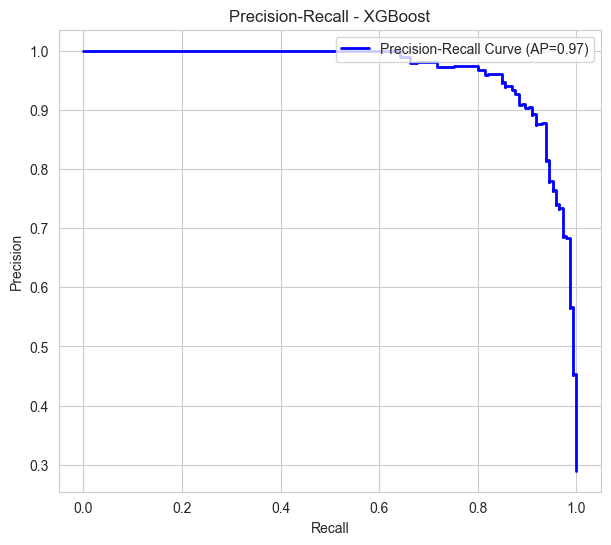


===== Training LightGBM =====
Training completed in 0.1564 seconds.
Making predictions with LightGBM...
Prediction completed in 0.0137 seconds.

--- Evaluating LightGBM ---
Accuracy: 0.9440
Weighted F1-Score: 0.9438

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       355
           1       0.91      0.89      0.90       145

    accuracy                           0.94       500
   macro avg       0.94      0.93      0.93       500
weighted avg       0.94      0.94      0.94       500



C:\Users\Satyam\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Satyam\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


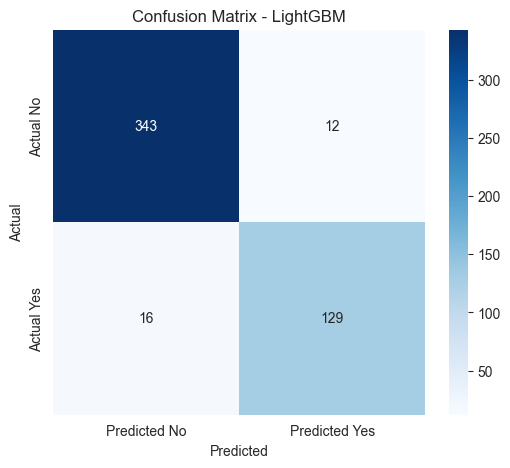

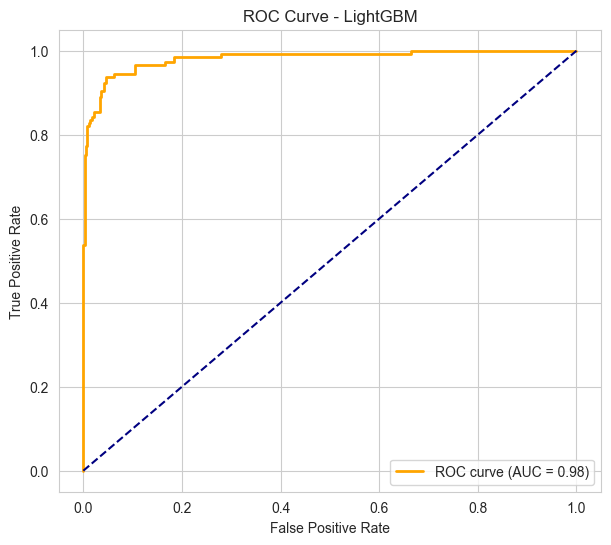

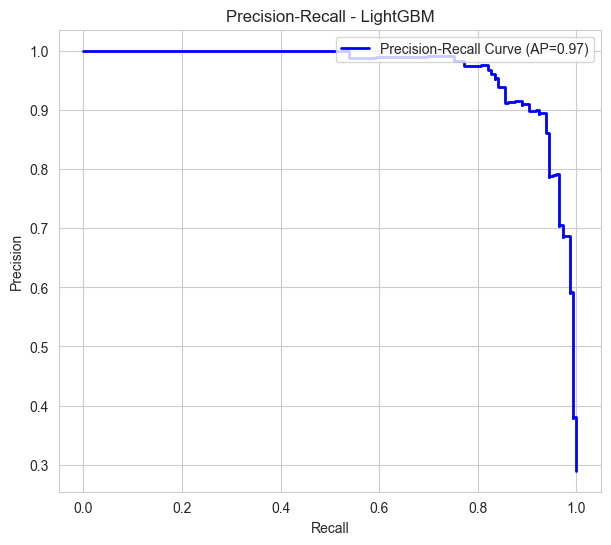

Could not retrieve feature names: 'onehot'
Feature importance length mismatch for LightGBM. Skipping visualization.


In [22]:
print("\n--- Starting Model Training & Evaluation ---")

for model_name, model in models.items():
    print(f"\n===== Training {model_name} =====")
    start_time = time.time()

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.4f} seconds.")

    print(f"Making predictions with {model_name}...")
    start_time = time.time()
    y_pred = pipeline.predict(X_test)

    y_prob = None
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        try:
            y_prob = pipeline.predict_proba(X_test)[:, 1]
        except Exception as e:
            print(f"Could not get probabilities for {model_name}: {e}")
    else:
        print(f"{model_name} does not support predict_proba.")

    predict_time = time.time() - start_time
    print(f"Prediction completed in {predict_time:.4f} seconds.")

    # --- Evaluation ---
    print(f"\n--- Evaluating {model_name} ---")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", report)

    results[model_name] = {
        'Accuracy': accuracy,
        'F1-Score (Weighted)': f1,
        'Confusion Matrix': cm,
        'Classification Report': report,
        'Training Time (s)': train_time,
        'Prediction Time (s)': predict_time,
        'Pipeline': pipeline,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

    # --- Visualization ---

    # Confusion Matrix Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve visualization (for applicable models)
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        # Precision-Recall Curves
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        plt.figure(figsize=(7, 6))
        plt.step(recall, precision, where='post', color='blue', lw=2,
                 label=f'Precision-Recall Curve (AP={avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall - {model_name}')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

# Feature Importance (if available)
feature_names = None
importances = None

try:
    preprocessor = pipeline.named_steps['preprocessor']
    numeric_features_names = numerical_features
    categorical_features_names = categorical_features

    # Retrieve numeric feature names directly
    feature_names = list(numeric_features_names)

    # Retrieve categorical feature names after one-hot encoding
    cat_features_out = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features_names)
    feature_names += list(cat_features_out)

except Exception as e:
    print(f"Could not retrieve feature names: {e}")
    feature_names = None

if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
elif hasattr(model, 'coef_'):
    importances = np.abs(model.coef_[0]) if model.coef_.ndim > 1 else np.abs(model.coef_)

# Check for matching feature names and importances lengths explicitly
if importances is not None and feature_names and len(importances) == len(feature_names):
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
    plt.title(f'Top 15 Feature Importances - {model_name}')
    plt.tight_layout()
    plt.show()
elif importances is not None:
    print(f"Feature importance length mismatch for {model_name}. Skipping visualization.")
else:
    print(f"No feature importances available for {model_name}.")



In [23]:
# --- Overall Results Summary & Visualization ---
print("\n--- Overall Results Summary ---")
summary_list = []
for name, res in results.items():
    summary_list.append({
        'Model': name,
        'Accuracy': res['Accuracy'],
        'F1-Score (Weighted)': res['F1-Score (Weighted)'],
        'Training Time (s)': res['Training Time (s)'],
    })

summary_df = pd.DataFrame(summary_list).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(summary_df)


--- Overall Results Summary ---
           Model  Accuracy  F1-Score (Weighted)  Training Time (s)
0            SVM     0.946             0.945945           0.166528
1        XGBoost     0.946             0.946055           0.056290
2       LightGBM     0.944             0.943765           0.156368
3            KNN     0.914             0.913356           0.011497
4  Decision Tree     0.906             0.905706           0.012065


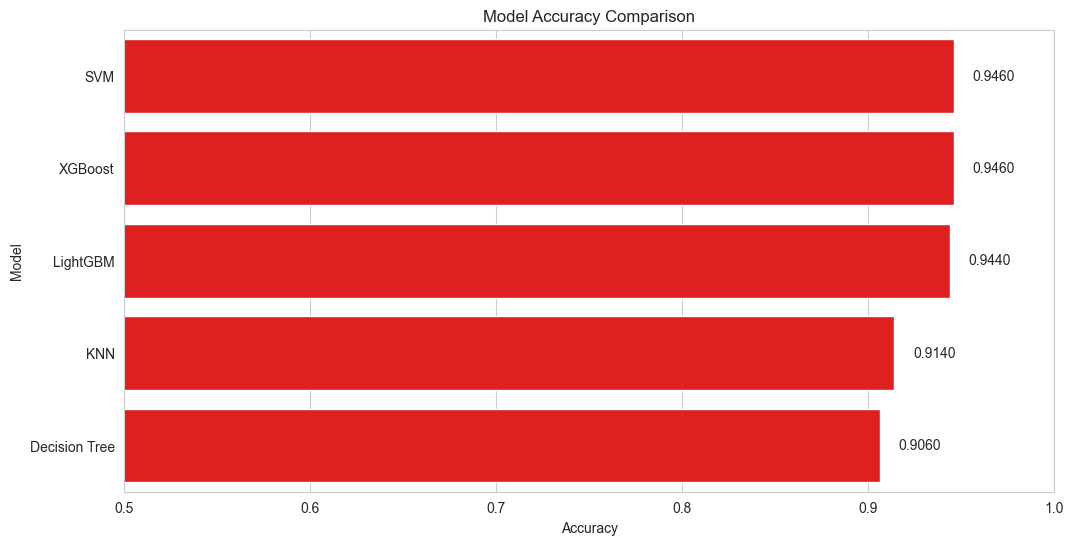

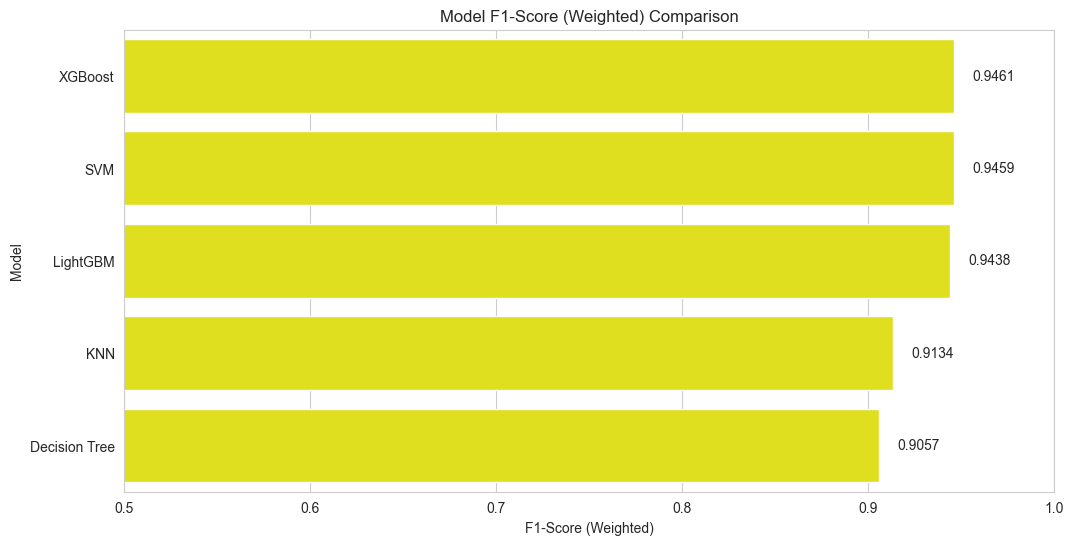

In [24]:
# Bar chart comparing model performance
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=summary_df, color='red')
plt.title('Model Accuracy Comparison')
plt.xlim(0.5, 1.0) # Adjust x-axis limits based on typical accuracy range
for index, value in enumerate(summary_df['Accuracy']):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center') # Add text labels
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='F1-Score (Weighted)', y='Model', data=summary_df.sort_values('F1-Score (Weighted)', ascending=False), color='yellow')
plt.title('Model F1-Score (Weighted) Comparison')
plt.xlim(0.5, 1.0) # Adjust x-axis limits
for index, value in enumerate(summary_df.sort_values('F1-Score (Weighted)', ascending=False)['F1-Score (Weighted)']):
     plt.text(value + 0.01, index, f'{value:.4f}', va='center') # Add text labels
plt.show()

In [25]:
print("\n--- Detailed Reports ---")
for model_name, res in results.items():
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {res['Accuracy']:.4f}")
    print(f"F1-Score (Weighted): {res['F1-Score (Weighted)']:.4f}")
    # print("Confusion Matrix:\n", res['Confusion Matrix']) # Plotted earlier
    print("Classification Report:\n", res['Classification Report'])



--- Detailed Reports ---

--- KNN ---
Accuracy: 0.9140
F1-Score (Weighted): 0.9134
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       355
           1       0.87      0.83      0.85       145

    accuracy                           0.91       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.91      0.91      0.91       500


--- Decision Tree ---
Accuracy: 0.9060
F1-Score (Weighted): 0.9057
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       355
           1       0.85      0.83      0.84       145

    accuracy                           0.91       500
   macro avg       0.89      0.88      0.89       500
weighted avg       0.91      0.91      0.91       500


--- SVM ---
Accuracy: 0.9460
F1-Score (Weighted): 0.9459
Classification Report:
               precision    recall  f1-score   support

         

In [31]:
import joblib # Make sure joblib is imported at the top

# Find the best model based on Accuracy (or F1-score)
# Ensure summary_df is sorted by Accuracy descending
summary_df = summary_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
best_model_name = summary_df.iloc[0]['Model']
best_model_accuracy = summary_df.iloc[0]['Accuracy']
best_model_pipeline = results[best_model_name]['Pipeline'] # Get the trained pipeline

# Define the path to save the model
save_path = f"best_plant_model.joblib"

# Save the best pipeline object
try:
    joblib.dump(best_model_pipeline, save_path)
    print(f"\n✅ Best model ({best_model_name} with Accuracy {best_model_accuracy:.4f}) saved successfully to: {save_path}")
except Exception as e:
    print(f"❌ Error saving model: {e}")


✅ Best model (SVM with Accuracy 0.9460) saved successfully to: best_plant_model.joblib
